In [1]:
import tensorflow as tf
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU를 찾았습니다')
else:
    print("GPU를 찾을 수 없습니다")

GPU를 찾았습니다


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16979243673879794413
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3646947328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11883156133323715641
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


## CiFAR 이미지 분류 모델 구현
---
- 데이터 : CiFAR10
- 학습방법 : 10가지 이미지 종류 분류 => 다중분류
- 이미지 : DNN(MLP), CNN 적용

In [3]:
# 모듈 로딩
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import set_random_seed, plot_model
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### [1] 데이터 준비 및 로딩

In [4]:
# ## 데이터 로딩
# from urllib.request import Request, urlopen, urlretrieve
# URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-matlab.tar.gz'
# FILE = 'CiFAR10'
# ret = urlretrieve(URL, FILE)

In [5]:
# load_data() 함수를 호출하면 NumPy 어레이의 튜플을 반환
(X_train, y_train), (X_test, y_test) = load_data()

In [6]:
print(f'X_train.shape : {X_train.shape}, y_train.shape : {y_train.shape}')
print(f'X_test.shape  : {X_test.shape}, y_test.shape  : {y_test.shape}')

X_train.shape : (50000, 32, 32, 3), y_train.shape : (50000, 1)
X_test.shape  : (10000, 32, 32, 3), y_test.shape  : (10000, 1)


[6], [9], [9], [4], [1], 

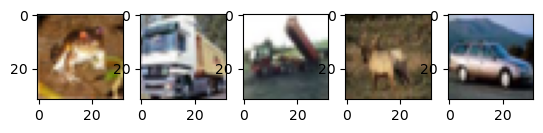

In [7]:
# 이미지 확인
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    print(y_train[i], end=", ")
plt.show()

### [2] 데이터 전처리 및 학습형태로 변환

In [8]:
# 스케일링 => 픽셀 / 255.0
X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
# Conv 레이어에서는 입력할 때, 채널값이 있어야 되니까 형태를 바꿔야 함
X_train = X_train.reshape(-1, 32, 32, 3)  # 마지막의 3은 컬러를 의미
X_test = X_test.reshape(-1, 32, 32, 3)   

In [10]:
print(f'X_train.shape : {X_train.shape}')  # 학습용
print(f'X_test.shape  : {X_test.shape}')   # 테스트용

X_train.shape : (50000, 32, 32, 3)
X_test.shape  : (10000, 32, 32, 3)


In [11]:
# 검증용 데이터셋 준비
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  stratify = y_train,
                                                  random_state=11)

In [12]:
print(f'X_train.shape : {X_train.shape}\nX_val.shape   : {X_val.shape}\nX_test.shape  : {X_test.shape}')
print(f'y_train.shape : {y_train.shape}\ny_val.shape   : {y_val.shape}\ny_test.shape  : {y_test.shape}')

X_train.shape : (37500, 32, 32, 3)
X_val.shape   : (12500, 32, 32, 3)
X_test.shape  : (10000, 32, 32, 3)
y_train.shape : (37500, 1)
y_val.shape   : (12500, 1)
y_test.shape  : (10000, 1)


### [3] 모델 구성 및 생성
---
- 입력 형태 : 채널 정보까지 포함 3차원 (32,32,3)
- 출력 형태 : 

### [3-1] 모델 구상

In [13]:
model = Sequential(name='CiFAR10_CNN') # 이름 한글로 하지 말 것

In [14]:
# filters : Kernel 그룹의 갯수 / kernel_size : Kernel 크기 (3 or (3,3))
# pool_size : MaxPooling 의 Window size

In [15]:
# 이미지 특징 추출 Layer => 첫번째 입력값 설정
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))

In [16]:
# Conv와 MaxPool2D는 한 세트로 생각하고 바로 입력
# 이미지 특징 다운샘플링 layer => MaxPool2D
model.add(MaxPool2D(pool_size=(2, 2)))

In [17]:
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

In [18]:
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

In [19]:
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

In [20]:
# 더이상 한 세트를 실행하지 않겠다 => 출력전 1차원으로 펴줘야 함
# 1차원으로 데이터 형태 변환 Layer => Flatten
model.add(Flatten())

In [21]:
# 결과 출력층 => Node : 0-9까지 10개, activation : softmax
model.add(Dense(10, activation='softmax'))

In [22]:
# 아웃풋으로 보는 것
model.summary()

Model: "CiFAR10_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                   

In [23]:
# 과정 시각화 (인풋도 볼 수 있즤)
# plot_model(model, show_shapes=True, to_file='CNN.png')

### [3-2] 모델 생성

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam', metrics='accuracy')
# 'adam' 말고 'sgd' & 해당 벡터 one-hot-encoding 해서도 해볼 것 => sgd(x)
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### [3-3] 모델 학습

In [25]:
with tf.device("/device:CPU:0"):
    model.fit(X_train, y_train, epochs=10)

Epoch 1/10
 415/1172 [=========>....................] - ETA: 57s - loss: 1.9485 - accuracy: 0.2752

KeyboardInterrupt: 

In [26]:
with tf.device("/device:GPU:0"):
    model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1172/1172 [==============================] - 14s 7ms/step - loss: 1.4236 - accuracy: 0.4768
Epoch 2/10
1172/1172 [==============================] - 7s 6ms/step - loss: 1.0795 - accuracy: 0.6163
Epoch 3/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.8819 - accuracy: 0.6868
Epoch 4/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.7556 - accuracy: 0.7346
Epoch 5/10
1172/1172 [==============================] - 9s 7ms/step - loss: 0.6470 - accuracy: 0.7691
Epoch 6/10
1172/1172 [==============================] - 9s 8ms/step - loss: 0.5547 - accuracy: 0.8032
Epoch 7/10
1172/1172 [==============================] - 9s 8ms/step - loss: 0.4767 - accuracy: 0.8296
Epoch 8/10
1172/1172 [==============================] - 9s 8ms/step - loss: 0.4080 - accuracy: 0.8553
Epoch 9/10
1172/1172 [==============================] - 9s 8ms/step - loss: 0.3491 - accuracy: 0.8733
Epoch 10/10
1172/1172 [==============================] - 9s 8ms/step - loss: 0.30

In [28]:
model.fit(X_train, y_train, epochs=10)
# batch_size=32

Epoch 1/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.2514 - accuracy: 0.9107
Epoch 2/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.2354 - accuracy: 0.9176
Epoch 3/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.2115 - accuracy: 0.9259
Epoch 4/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.2195 - accuracy: 0.9235
Epoch 5/10
1172/1172 [==============================] - 8s 6ms/step - loss: 0.1955 - accuracy: 0.9331
Epoch 6/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.2082 - accuracy: 0.9288
Epoch 7/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.1966 - accuracy: 0.9342
Epoch 8/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.1893 - accuracy: 0.9352
Epoch 9/10
1172/1172 [==============================] - 8s 6ms/step - loss: 0.1882 - accuracy: 0.9362
Epoch 10/10
1172/1172 [==============================] - 8s 7ms/step - loss: 0.193

### [4] 평가

In [30]:
# 테스트 값에서 하나 뽑아서
X_test[0]

array([[[0.61960784, 0.43921569, 0.19215686],
        [0.62352941, 0.43529412, 0.18431373],
        [0.64705882, 0.45490196, 0.2       ],
        ...,
        [0.5372549 , 0.37254902, 0.14117647],
        [0.49411765, 0.35686275, 0.14117647],
        [0.45490196, 0.33333333, 0.12941176]],

       [[0.59607843, 0.43921569, 0.2       ],
        [0.59215686, 0.43137255, 0.15686275],
        [0.62352941, 0.44705882, 0.17647059],
        ...,
        [0.53333333, 0.37254902, 0.12156863],
        [0.49019608, 0.35686275, 0.1254902 ],
        [0.46666667, 0.34509804, 0.13333333]],

       [[0.59215686, 0.43137255, 0.18431373],
        [0.59215686, 0.42745098, 0.12941176],
        [0.61960784, 0.43529412, 0.14117647],
        ...,
        [0.54509804, 0.38431373, 0.13333333],
        [0.50980392, 0.37254902, 0.13333333],
        [0.47058824, 0.34901961, 0.12941176]],

       ...,

       [[0.26666667, 0.48627451, 0.69411765],
        [0.16470588, 0.39215686, 0.58039216],
        [0.12156863, 0

### [5] 테스트

In [31]:
pre_y = model.predict(X_test[0].reshape(-1,32,32,3))

In [32]:
# 0-9 순서대로 나올 확률이 적힌 것인데, 9일 확률이 0.99로 가장 높음
pre_y.round(2), pre_y.shape

(array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32), (1, 10))

In [33]:
y_test[0]

array([3], dtype=uint8)